In [48]:
# Elementy Sztucznej Inteligencji
# Informatyka i Ekonometria, IV semestr, WZ, AGH.

# Grupa 3
# "Obliczanie szans na choroby wieńcowe/atak serca"
# Paweł Brodziak
# Magdalena Leśniak

# Tworzenie sieci neuronowej z użyciem funkcji progowej unipolarnej (binary step)

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

In [50]:
#Pobranie danych z pliku Excel
df = pd.read_excel('data_heart_disease.xlsx')

In [51]:
#Podział danych na część uczącą i testową (80:20)
df_learn = df.iloc[:int(0.8*len(df)),:]
df_test = df.iloc[int(0.8*len(df)):,:]

In [52]:
#Zamiana danych na dane wejściowe X i dane docelowe (wyniki) y w formacie numpy
X = np.array([df_learn.HighBP,df_learn.HighChol,df_learn.CholCheck,df_learn.BMI,df_learn.Smoker,df_learn.Stroke,df_learn.Diabetes,df_learn.PhysActivity,df_learn.Fruits,df_learn.Veggies,df_learn.HvyAlcoholConsump,df_learn.DiffWalk,df_learn.Sex,df_learn.Age]).transpose()

df_learn_y = pd.DataFrame(df_learn.HeartDiseaseorAttack)
y = np.array(df_learn_y)

X = X/np.amax(X, axis=0) #Standaryzacja danych wejściowych (0-1)

In [53]:
#Zamiana danych na format numpy dla X i y testowych
test_X = np.array([df_test.HighBP,df_test.HighChol,df_test.CholCheck,df_test.BMI,df_test.Smoker,df_test.Stroke,df_test.Diabetes,df_test.PhysActivity,df_test.Fruits,df_test.Veggies,df_test.HvyAlcoholConsump,df_test.DiffWalk,df_test.Sex,df_test.Age]).transpose()

df_test_y = pd.DataFrame(df_test.HeartDiseaseorAttack)
test_y = np.array(df_test_y)

test_X = test_X/np.amax(test_X, axis=0) #Standaryzacja danych testowych (0-1)

In [64]:
#Stworzenie klasy sieci neuronowej
class Neural_Network(object):
    def __init__(self, Lambda=0):
        #Definiowanie globalnych parametrów sieci
        self.inputLayerSize = 14
        self.outputLayerSize = 1
        self.firstHiddenLayerSize = 8
        self.secondHiddenLayerSize = 4

        #Wagi (parametry - pierwsze losowe)
        self.W1 = np.random.randn(self.inputLayerSize, self.firstHiddenLayerSize)
        self.W2 = np.random.randn(self.firstHiddenLayerSize, self.secondHiddenLayerSize)
        self.W3 = np.random.randn(self.secondHiddenLayerSize, self.outputLayerSize)

        #Parametr regularyzujący Lambda
        self.Lambda = Lambda

    def binaryStep(self, z):
    #Zastosowuje funkcję aktywacyjną - Funkcja progowa unipolarna
        for i in range(0,len(z)):
            try:
                for j in range(0,len(z[i])):
                    if z[i][j] < 0:
                         z[i][j] = 0
                    else:
                        z[i][j] = 1
            except TypeError:
                if z[i] < 0:
                    z[i] = 0
                else:
                    z[i] = 1
        return z

    def binaryPrime(self,z):
        #Pochodna funkcji progowej - oblicza gradient funkcji
        return np.zeros(z.shape)

    def predict(self, X):
        #Funkcja obliczająca predykcje y (y-hat) na podstawie iloczynu skalarnego danych wejściowych i wag pomiędzy neuronami
        self.z1 = np.dot(X, self.W1)
        self.s1 = self.binaryStep(self.z1)
        self.z2 = np.dot(self.s1, self.W2)
        self.s2 = self.binaryStep(self.z2)
        self.z3 = np.dot(self.s2, self.W3)
        y_hat = self.binaryStep(self.z3)
        return y_hat

    def costFunction(self, X, y):
        #Oblicza koszt J dla podanych X,y korzystając z kwadratu błędów oraz dodaje regularyzację z użyciem wag zapisanych w klasie.
        self.y_hat = self.predict(X)
        J = 0.5*np.sum((y-self.y_hat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2)+np.sum(self.W3**2))
        return J

    def gradientFunction(self, X, y):
        #Oblicza pochodną dla X oraz y uwzględniając wagi zapisane w klasie
        self.y_hat = self.predict(X)

        #Dodanie gradientu regularyzacji w celu polepszenia jakości rozwiązania

        d3 = np.multiply(-(y-self.y_hat), self.binaryPrime(self.z3))
        dJW3 = np.dot(self.s2.T, d3)/X.shape[0] + self.Lambda*self.W3

        d2 = np.dot(d3, self.W3.T)*self.binaryPrime(self.z2)
        dJW2 = np.dot(self.s1.T, d2)/X.shape[0] + self.Lambda*self.W2

        d1 = np.dot(d2, self.W2.T)*self.binaryPrime(self.z1)
        dJW1 = np.dot(X.T, d1)/X.shape[0] + self.Lambda*self.W1

        return dJW1, dJW2, dJW3

    def saveErrors(self):
        #Zbiór funkcji podający nowe paramtery wag do sieci i dodający błedy obliczone po wybranych iteracjach
        self.J.append(self.costFunction(self.X, self.y))
        self.testJ.append(self.costFunction(self.testX, self.testY))

    def train(self, trainX, trainY, testX, testY, iterations):
        #Tworzenie lokalnych zmiennych używanych przez funkcje klasy
        self.X = trainX
        self.y = trainY
        self.testX = testX
        self.testY = testY

        #Stworzenie pustych list aby zapisywać koszty obliczane co 100 iteracji
        self.J = []
        self.testJ = []

        batch_size = 100
        n_obs = X.shape[0]

        xy = np.c_[X.reshape(n_obs, -1), y.reshape(n_obs, 1)]

        seed = None
        rng = np.random.default_rng(seed=seed)

        for _ in range(iterations):
            rng.shuffle(xy)
            for start in range(0, n_obs, batch_size):
                stop = start + batch_size
                x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]
                dW1, dW2, dW3 = self.gradientFunction(x_batch,y_batch)
                self.W1 = self.W1 - (dW1 * self.Lambda)
                self.W2 = self.W2 - (dW2 * self.Lambda)
                self.W3 = self.W3 - (dW3 * self.Lambda)
            self.saveErrors()

        currentJ = self.costFunction(self.X,self.y) / self.Lambda
        current_testJ = self.costFunction(self.testX,self.testY) / self.Lambda
        result = f'''Po {iterations} iteracjach, błąd predykcji sieci neuronowej wynosi {currentJ} dla danych uczących oraz {current_testJ} dla danych testowych'''

        return result

In [65]:
NN = Neural_Network(Lambda = 0.001 )

In [66]:
start_time = time.time()
result = NN.train(X,y, test_X, test_y, 1000)
print(f'''
{result}
Trening zajął %.5s sekund'''% (time.time() - start_time))

'Po 500 iteracjach, błąd predykcji sieci neuronowej wynosi 59.35141754205942 dla danych uczących oraz 58.39795254678979 dla danych testowych'

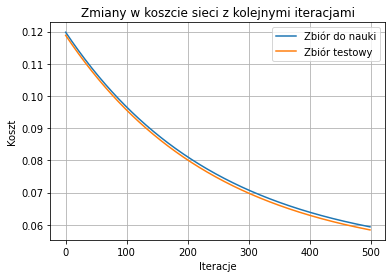

In [67]:
plt.plot(NN.J, label='Zbiór do nauki')
plt.plot(NN.testJ, label='Zbiór testowy')
plt.grid(1)
plt.title('Zmiany w koszcie sieci z kolejnymi iteracjami')
plt.xlabel('Iteracje')
plt.ylabel('Koszt')
plt.legend()
plt.show()

In [80]:
test = np.array([0,1,1,0.4,0,1,0,0,0,0,1,1,1,0.7]) ## Predykcja dla testowej osoby o wybranych cechach
NN.predict(test)

array([1.])

In [73]:
## Obliczanie stosunku poprawnych przewidywań do liczby wszystkich danych w próbie
y_hat = NN.predict(X)
counter = 0
for i in range(0,y_hat.shape[0]):
    if y_hat[i] == y[i]:
        counter += 1
correct_ratio = counter / y_hat.shape[0] * 100
correct_ratio

89.96619757174393

In [81]:
## Obliczanie stosunku poprawnych przewidywań do liczby wszystkich danych w próbie testowej
y_hat_test = NN.predict(test_X)
counter = 0
for i in range(0,y_hat_test.shape[0]):
    if y_hat_test[i] == test_y[i]:
        counter += 1
correct_ratio = counter / y_hat_test.shape[0] * 100
correct_ratio

90.15689057079786